In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib  widget

In [5]:
# how many dates do we have? 
workdir = '/data/ocp4/LagunaSalada/'
alooks=4
rlooks=20
#cropdir='cropped_9000_20_10000_1780/'
cropdir='cropped_9000_1800_18000_3600/'

LSx=14500
LSy=1800
notLSx=16000
notLSy=1800

# October 30, 2022 run these coords: 
LSx=15000
LSy=1500
notLSx=16500
notLSy=1500

# testing another set of pixels 
#LSx=15080
#LSy=1576
#notLSx=16100
#notLSy=1576

dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vh/2*")]
dates=sorted(dates)
print(str(len(dates))+' dates so far!')
nd=len(dates)
#print(type(dates))
#print(dates)

# convert these strings to datetime 


211 dates so far!


In [7]:
# initializing empty arrays, they are 3 dimensional 
# will contain a layer for each date with layer containing alooks x rlooks pixels from each SLC
slcLS=np.ndarray([len(dates),alooks,rlooks],'complex')
slcNotLS=np.ndarray([len(dates),alooks,rlooks],'complex')

# pull out the alooks x rlooks box of pixels from pixel in Cerro Prieto geothermal field  
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", gdal.GA_ReadOnly)
    slcLS[i,:,:] = ds.GetRasterBand(1).ReadAsArray(LSx-rlooks/2,LSy-alooks/2,rlooks,alooks)

# do the same for the pixel just outside of LS 
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", gdal.GA_ReadOnly)
    slcNotLS[i,:,:] = ds.GetRasterBand(1).ReadAsArray(notLSx-rlooks/2,notLSy-alooks/2,rlooks,alooks)
    

In [8]:
# initialize empty arrays for storing coherence values for each SLC pair/igram
# phase is difference (conjugate) between  at pt 1 and pt 2
allphase=np.zeros([nd-1,1])
coh=np.zeros([nd-1,1]) # this is for the average coh between the two points
cohLS=np.zeros([nd-1,1])
cohnotLS=np.zeros([nd-1,1])

# assigning integer values to SLC pairs 
numints = np.cumsum(np.arange(nd))
numints=np.max(numints)
# what does this do?
ids=np.ndarray([numints,2])

# making interferograms, looping thru i, j dates 
for i in np.arange(nd-1):
    j = i+1
    # is is first date, j is comparison date

    
    # Using this method: <a b*> / <abs(a b*)>

    # a b*
    ints=slcLS[i,:,:] * np.conj(slcLS[j,:,:])
    ints2=slcNotLS[i,:,:] * np.conj(slcNotLS[j,:,:])
    # take the mean over all the pixels in this area (complex space) complex coherence
    # <a b*>
    cov=np.mean(ints,axis=(0,1)) # complex number, of which phase is angle 
    # mag of this is the coherence at that point 
    cov2=np.mean(ints2,axis=(0,1))
    # <abs (a b*)>
    intmag=np.mean(np.abs(ints),axis=(0,1))
    intmag2=np.mean(np.abs(ints2),axis=(0,1))
    # coherence magnitude, simplest way of doing it 
    # <a b*> / <abs(a b*)>
    covw = cov/intmag
    covw2 = cov2/intmag2
    # put these into a 2-element array
    toAvg = [covw, covw2]
    # average the two coherence magnitudes from the two points
    coh[i] = np.mean(np.abs(toAvg))
    
    # coh at LS pixel and outside LS pixel 
    cohLS[i] = np.abs(covw)
    cohnotLS[i] = np.abs(covw2)

    # now we have covs at pt 1 and 2 
    allphase[i]=np.angle(cov*np.conj(cov2))

    # angle instead of mag
    #allphase[i,j]=np.angle(covw)
    
#print(np.shape(cov))
#print(cov)
#print(covw)
#print(covw2)
#print(coh[0:10])


In [9]:
# calculate phase change over each igram interval 

# dates is a list of strings, from cell above.

# convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))

# calculate dt between slcs 
dt = np.diff(slc_dates)
# these are now timedelta objects

# convert to floats 
dt2 = np.zeros([len(dt),1])

for i in range(0,len(dt)):
    dt2[i] = dt[i].days
# dt2 is now an array of floats

In [10]:
# Read in precipitation data and plot it 
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip.txt', delimiter=',', skiprows=3, dtype=str)

precipDates = precip[:,0]
precip = precip[:,1]
#print(type(precip[0]))
precip = precip.astype(float)
#print(precip)
# convert to cm from inches 
precip = precip*2.54

# make the dates from precip.txt into datetime objects
my_dates=[]
for i in range(0,len(precipDates)):
    my_dates.append(datetime.strptime(str(precipDates[i]).replace('\n',''), '%Y-%m-%d'))
    

In [11]:
# Read in 2-day precipitation data
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')

# BIGGER STORMS
# days with precip > 0.3cm 
print('date \t\t       precip > 0.3cm')
rain_dates = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.3:
        print(str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])

date 		       precip > 0.3cm
2017-05-10 00:00:00    0.33020000000000005 cm
2018-12-07 00:00:00    5.0546 cm
2019-09-27 00:00:00    1.4478 cm
2019-11-20 00:00:00    2.286 cm
2020-02-12 00:00:00    1.1684 cm
2020-03-13 00:00:00    0.40640000000000004 cm
2020-04-12 00:00:00    0.9906 cm
2021-08-11 00:00:00    0.381 cm


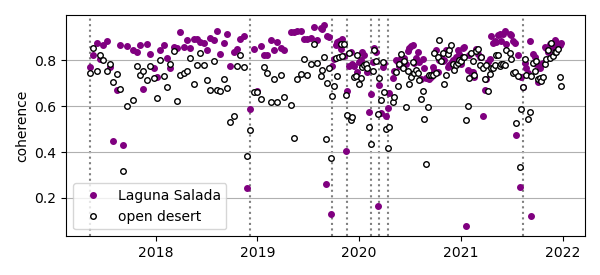

In [16]:
# plot coherence over time at a pixel 
plt.figure(figsize=(6, 2.75), tight_layout=True)
ax = plt.subplot(1, 1, 1)

ax.set_ylabel('coherence')
#plt.xlabel('time')
#ax.plot(slc_dates[0:-1],cohLS,'ko',ms=4,label='pixel in Laguna Salada')
#ax.plot(slc_dates[0:-1],cohnotLS,'wo',ms=4,mec='k',label='pixel outside of Laguna Salada')
ax.plot(slc_dates[0:-1],cohLS,'.',color='purple',markersize=8,label='Laguna Salada',zorder=3)
ax.plot(slc_dates[0:-1],cohnotLS,'.',color='white',markersize=8,mec='k',label='open desert',zorder=10)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])

ax.grid(axis='y')
#plt.legend(bbox_to_anchor=(0.25, 1))
plt.legend(loc='lower left')
plt.show()

plt.savefig("coh_time.pdf", transparent=True)


In [12]:
# writing the coherences to a text file to use in my Inverse final project 11-26-22
import csv

with open('coh_in_LS.txt', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(cohLS)

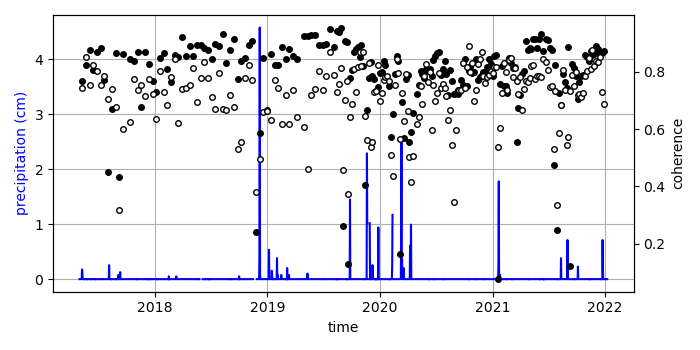

In [16]:
# plot coherence over time at a pixel 
plt.figure(figsize=(7, 3.5), tight_layout=True)
ax = plt.subplot(1, 1, 1)

ax.set_ylabel('precipitation (cm)', c='b')
ax.plot(my_dates, precip,'-b')
# trying a weird upside down precip plot
#ax.set_ylim([5,-0.1])
plt.xlabel('time')

ax2 = ax.twinx()
ax2.plot(slc_dates[0:-1],cohLS,'ko',ms=4,label='pixel in Laguna Salada')
ax2.plot(slc_dates[0:-1],cohnotLS,'wo',ms=4,mec='k',label='pixel outside of Laguna Salada')
plt.ylabel('coherence')

ax.grid('on')
#plt.legend(bbox_to_anchor=(0.25, 1))
#plt.legend()
plt.show()


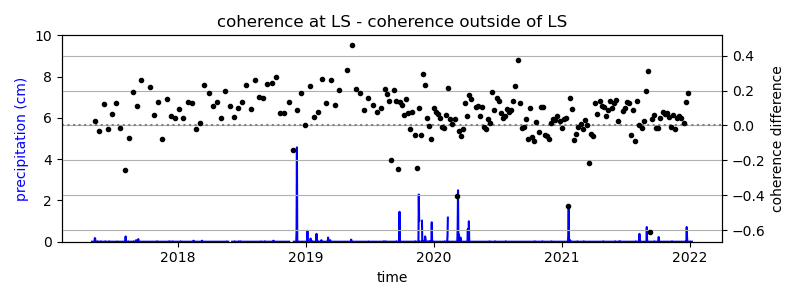

In [17]:
# what about the difference between the two? coh outside LS-coh in LS

# plot diff in coherence over time
plt.figure(figsize=(8, 3), tight_layout=True)
ax = plt.subplot(1, 1, 1)

ax.set_ylabel('precipitation (cm)', c='b')
ax.plot(my_dates, precip,'-b')
ax.set_ylim([0,10])
plt.xlabel('time')

ax2 = ax.twinx()
plt.axhline(y=0, color='gray', linestyle=':')
ax2.plot(slc_dates[0:-1],cohLS-cohnotLS,'k.')
plt.ylabel('coherence difference')
plt.title('coherence at LS - coherence outside of LS')

ax2.grid('on')
plt.show()


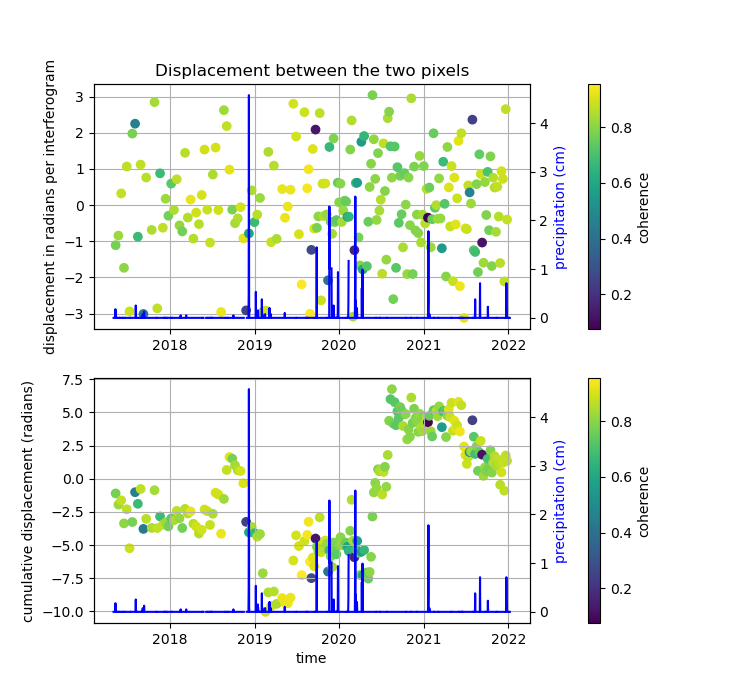

In [18]:
cumulative = np.cumsum(allphase)
# try a cumulative sum? See them go up? 

plt.figure(figsize=(7.5, 7))
ax = plt.subplot(2, 1, 1)

# ZORDER NOT WORKING !!!
plt.scatter(slc_dates[0:-1],allphase, c=cohLS, zorder=3.5)
plt.grid('on')
cbar = plt.colorbar(pad=0.1)
cbar.set_label('coherence')
#plt.xlim([np.min(slc_dates), np.max(slc_dates)])
plt.ylabel('displacement in radians per interferogram')
plt.title('Displacement between the two pixels')

ax2 = ax.twinx()
ax2.set_ylabel('precipitation (cm)', c='b', zorder=2.5)
ax2.plot(my_dates, precip,'-b')


ax = plt.subplot(2, 1, 2)
plt.scatter(slc_dates[0:-1],cumulative, c=cohLS)
plt.grid('on')
cbar = plt.colorbar(pad=0.1)
cbar.set_label('coherence')
plt.xlabel('time')
plt.ylabel('cumulative displacement (radians)')

ax2 = ax.twinx()
ax2.set_ylabel('precipitation (cm)', c='b')
ax2.plot(my_dates, precip,'-b')

plt.show()

# last coherence value is zero (because it isn't a real igram?)
#print(coh[-1])



In [19]:
#CONVERTING RADIANS TO CM 

#print(np.shape(dt2))
#print(len(slc_dates))
#print(len(allphase))
#print(len(coh))

# what about cm/year instead of radians/time interval of igram

# element by element multiplication, just in case
#allphase2 = np.multiply(allphase,dt2) # so this is radians/year now
dispcm = allphase*5.6/(4*np.pi) # disp/igram

r = dispcm*365.25

ratecm = r/dt2

cumulative2 = np.cumsum(dispcm,0)
# try a cumulative sum? See them go up? 

#print(np.shape(cumulative2))
#print(np.shape(disp))

avgrate = np.mean(ratecm)
print(avgrate)

0.25771255721500963


In [20]:
print("allphase: "+str(np.shape(allphase)))
print("slc_dates: "+str(np.shape(slc_dates)))
print("dispcm: "+str(np.shape(dispcm)))
print("ratecm: "+str(np.shape(ratecm)))
print("coh: "+str(np.shape(coh)))
print("dt2: "+str(np.shape(dt2)))

allphase: (210, 1)
slc_dates: (211,)
dispcm: (210, 1)
ratecm: (210, 1)
coh: (210, 1)
dt2: (210, 1)


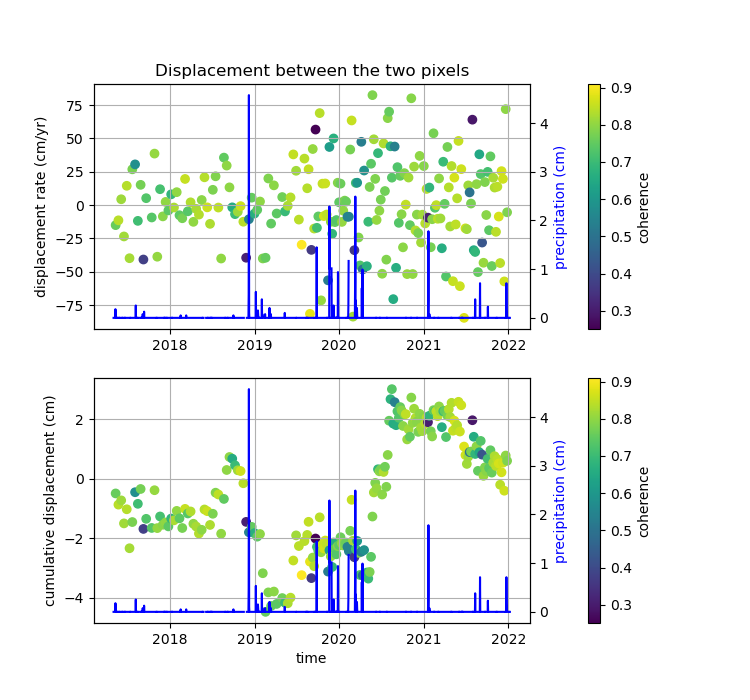

In [21]:
# Plots both together 

plt.figure(figsize=(7.5, 7))
ax = plt.subplot(2, 1, 1)

plt.scatter(slc_dates[0:-1], ratecm, c=coh)
plt.grid('on')
cbar = plt.colorbar(pad=0.1)
cbar.set_label('coherence')
#plt.xlim([np.min(slc_dates), np.max(slc_dates)])
plt.ylabel('displacement rate (cm/yr)')
plt.title('Displacement between the two pixels')
# 20190816 is when the 6-day pairs started 
#plt.axvline(x = datetime(2019, 8, 16, 0, 0), color='k')
ax2 = ax.twinx()
ax2.set_ylabel('precipitation (cm)', c='b')
ax2.plot(my_dates, precip,'-b')

ax = plt.subplot(2, 1, 2)
plt.scatter(slc_dates[0:-1], cumulative2, c=coh)
plt.grid('on')
cbar = plt.colorbar(pad=0.1)
cbar.set_label('coherence')
plt.xlabel('time')
plt.ylabel('cumulative displacement (cm)')
ax2 = ax.twinx()
ax2.set_ylabel('precipitation (cm)', c='b')
ax2.plot(my_dates, precip,'-b')

plt.show()

In [22]:
# calculate average subsidence rate 

r = (allphase.mean())
print('Mean phase value between igrams: '+str(r)+' radians')
# r is the radians 

# the error on the mean is std/sqrt(num dates)
s = allphase.std()/np.sqrt(len(slc_dates))
print('Error on the mean: '+str(s)+' radians') 
# this is the error on the mean 13 ~~sqrt(200 dates)

# converting to cm/yr disp.
avgDisp = r/(4*np.pi)*5.6*365/12
print('If each time interval was 12 days, disp would be: '+str(avgDisp)+' cm/yr')
# not each igram is 12 days, divide each value by time interval 


# calculate for each time interval 
disp = np.zeros(len(allphase))

#print(len(allphase)) #191 long
#print(len(disp))     #191 long
#print(len(dt2))      #190 long 




Mean phase value between igrams: 0.00641381112252164 radians
Error on the mean: 0.09470849851683873 radians
If each time interval was 12 days, disp would be: 0.08693725988163775 cm/yr


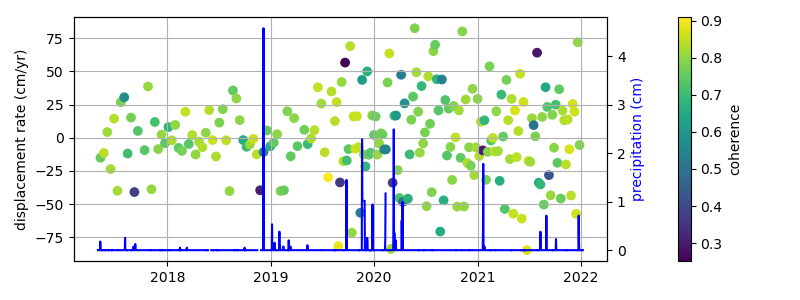

In [23]:
# Now plot them separately 

plt.figure(figsize=(8, 3), tight_layout=True)
ax = plt.subplot(1, 1, 1)

plt.scatter(slc_dates[0:-1], ratecm, c=coh)
plt.grid('on')
cbar = plt.colorbar(pad=0.1)
cbar.set_label('coherence')
#plt.xlim([np.min(slc_dates), np.max(slc_dates)])
plt.ylabel('displacement rate (cm/yr)')
#plt.title('Displacement between the two pixels')
# 20190816 is when the 6-day pairs started 
#plt.axvline(x = datetime(2019, 8, 16, 0, 0), color='k')
ax2 = ax.twinx()
ax2.set_ylabel('precipitation (cm)', c='b')
ax2.plot(my_dates, precip,'-b')
plt.show()

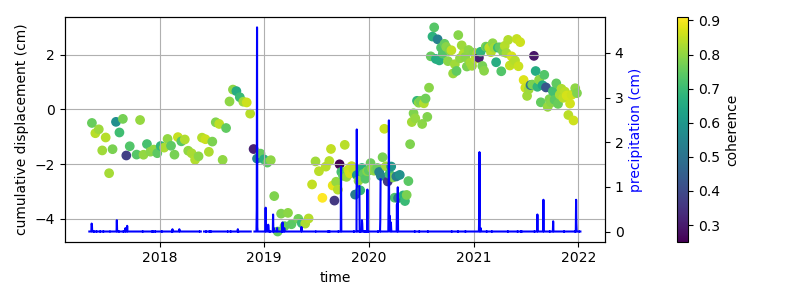

In [24]:
plt.figure(figsize=(8, 3), tight_layout=True)
ax = plt.subplot(1, 1, 1)
#plt.plot(slc_dates[0:-1], cumulative2, 'k-')
plt.scatter(slc_dates[0:-1], cumulative2, c=coh)
plt.grid('on')
cbar = plt.colorbar(pad=0.1)
cbar.set_label('coherence')
plt.xlabel('time')
plt.ylabel('cumulative displacement (cm)')
ax2 = ax.twinx()
ax2.set_ylabel('precipitation (cm)', c='b')
ax2.plot(my_dates, precip,'-b')
plt.show()